# 🩺 BRFSS Asthma Analysis Notebook

This notebook explores data from the 2021 Behavioral Risk Factor Surveillance System (BRFSS), focusing on individuals who reported having asthma. The analysis includes data cleaning, labeling, and summary statistics of key demographic and health behavior variables. The notebook also explores associations between asthma status and smoking behavior, BMI, and age.

---

## 📚 Notebook Sections Summary

### 1. Load Data
The dataset is loaded and inspected to verify its structure and ensure successful ingestion. This includes checking column names, data types, and sample values.

### 2. Data Cleaning and Labeling
This section addresses data quality issues such as missing values, inconsistent labels, and improper data types. Categorical variables are appropriately labeled for ease of interpretation.

### 3. Demographic Summary
Key demographic distributions (age, gender, race, education, and income) are summarized to understand the characteristics of the respondents, stratified by asthma status.

### 4. Smoking and Asthma
We explore the relationship between smoking behavior and asthma prevalence to examine smoking as a potential risk factor.

### 5. BMI Distribution
BMI is analyzed in relation to asthma status. Visualization tools help illustrate differences in BMI categories between asthma and non-asthma groups.

### 6. Visualizing Age Distribution for Asthma and Non-Asthma
This section presents histograms and density plots of age distributions for individuals with and without asthma to observe age-related trends.

### 7. Using FIPS to Map Asthma Cases
We utilize Federal Information Processing Standards (FIPS) codes to map the geographical distribution of asthma prevalence across the U.S., offering spatial insights into regional patterns.

---


## 1. Load Data
This section loads the BRFSS 2021 dataset and supporting metadata such as variable labels and FIPS code mappings. These are essential for interpreting and labeling categorical variables like state codes and demographic groups.

In [1]:
import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

warnings.filterwarnings('ignore')

## 2. Data Cleaning and Labeling
In this step, we address missing values, transform raw numeric codes into categorical labels (e.g., for age, sex, smoking), and ensure data types are appropriate for analysis. This step includes mapping variables like `_AGEG5YR`, `SEXVAR`, `EMPLOY1`, and `_SMOKER3` to human-readable labels.

In [3]:
df_asthma = pd.read_csv('https://raw.githubusercontent.com/seanlam74/CGH_SUTD_DVSA_Case_Study/refs/heads/main/brfss2021_asthma.csv')
df_asthma.columns

Index(['_AGEG5YR', '_AGE80', 'SEXVAR', '_IMPRACE', 'EDUCA', '_INCOMG1',
       'EMPLOY1', 'MARITAL', '_STATE', '_SMOKER3', '_BMI5', 'IDATE', 'SEQNO',
       'ASTHMA3', 'ASTHNOW'],
      dtype='object')

In [4]:
cat_vars = ['_AGEG5YR', 'SEXVAR', '_IMPRACE', 'EDUCA', '_INCOMG1',
            'EMPLOY1', 'MARITAL', '_STATE', '_SMOKER3','ASTHMA3','ASTHNOW']
# Convert categorical variables using .loc
for col in cat_vars:
    df_asthma.loc[:, col] = df_asthma[col].astype('category')


# Convert _BMI5 to numeric and scale to normal BMI range (divide by 100)


df_asthma.loc[:, '_BMI5'] = pd.to_numeric(df_asthma['_BMI5'], errors='coerce') / 100
df_asthma.loc[:, 'IDATE'] = pd.to_datetime(df_asthma['IDATE'], errors='coerce')


In [5]:
df_asthma.dtypes

,0
_AGEG5YR,category
_AGE80,float64
SEXVAR,category
_IMPRACE,category
EDUCA,category
_INCOMG1,category
EMPLOY1,category
MARITAL,category
_STATE,category
_SMOKER3,category


In [6]:
age_map = {
    1: '18–24', 2: '25–29', 3: '30–34', 4: '35–39', 5: '40–44',
    6: '45–49', 7: '50–54', 8: '55–59', 9: '60–64', 10: '65–69',
    11: '70–74', 12: '75–79', 13: '80+', 14: 'Unknown'
}

sex_map = {
    1: 'Male', 2: 'Female', 9: 'Refused'
}

imprace_map = {
    1: 'White NH', 2: 'Black NH', 3: 'Asian NH', 4: 'Pacific NH',
    5: 'FirstNation NH', 6: 'Multiracial NH', 7: 'Hispanic', 9: 'Unknown'
}

educa_map = {
    1: 'No formal education', 2: 'Grades 1–8', 3: 'Grades 9–11',
    4: 'High school graduate', 5: 'Some college',
    6: 'College graduate', 9: 'Refused'
}

incomg_map = {
    1: '<$15,000', 2: '$15–25k', 3: '$25–35k', 4: '$35–50k',
    5: '$50–75k', 6: '$75k+', 9: 'Unknown'
}

employ_map = {
    1: 'Employed for wages', 2: 'Self-employed', 3: 'Out of work ≥1yr',
    4: 'Out of work <1yr', 5: 'Homemaker', 6: 'Student',
    7: 'Retired', 8: 'Unable to work', 9: 'Refused'
}

marital_map = {
    1: 'Married', 2: 'Divorced', 3: 'Widowed',
    4: 'Separated', 5: 'Never married', 6: 'Unmarried couple', 9: 'Refused'
}

smoker_map = {
    1: 'Current smoker (every day)',
    2: 'Current smoker (some days)',
    3: 'Former smoker',
    4: 'Never smoked',
    9: "Don't know / Refused / Missing"
}

asthma3_map = {
    1: 'Yes',
    2: 'No',
    7: "Don't know / Not sure",
    9: 'Refused',
    # Missing values in data may appear as NaN or blank
}

asthnow_map = {
    1: 'Yes',
    2: 'No',
    7: "Don't know / Not sure",
    9: 'Refused',
    # Missing values: not asked (e.g. ASTHMA3 ≠ 1), will appear as NaN
}

# Apply mappings
df_asthma.loc[:, '_AGEG5YR'] = df_asthma['_AGEG5YR'].map(age_map)
df_asthma.loc[:, 'SEXVAR'] = df_asthma['SEXVAR'].map(sex_map)
df_asthma.loc[:, '_IMPRACE'] = df_asthma['_IMPRACE'].map(imprace_map)
df_asthma.loc[:, 'EDUCA'] = df_asthma['EDUCA'].map(educa_map)
df_asthma.loc[:, '_INCOMG1'] = df_asthma['_INCOMG1'].map(incomg_map)
df_asthma.loc[:, 'EMPLOY1'] = df_asthma['EMPLOY1'].map(employ_map)
df_asthma.loc[:, 'MARITAL'] = df_asthma['MARITAL'].map(marital_map)
df_asthma.loc[:, '_SMOKER3'] = df_asthma['_SMOKER3'].map(smoker_map)
df_asthma.loc[:, 'ASTHMA3'] = df_asthma['ASTHMA3'].map(asthma3_map)
df_asthma.loc[:, 'ASTHNOW'] = df_asthma['ASTHNOW'].map(asthnow_map)

## 3. Demographic Summary
This section summarizes key demographic features of the study population, including age group, sex, income, education, employment status, marital status, and race/ethnicity. Frequencies and proportions are calculated to support descriptive statistics in Table 1 format.

In [7]:
def summarize_unique_values(df):
    data = {col: [df[col].unique().tolist()] for col in df.columns}
    return pd.DataFrame.from_dict(data, orient='columns')

In [8]:
summary_df = summarize_unique_values(df_asthma).T.reset_index()
summary_df.columns = ['Variable', 'Unique Values']
summary_df

,Variable,Unique Values
0,_AGEG5YR,"[70–74, 65–69, 60–64, 75–79, 80+, 50–54, Unkno..."
1,_AGE80,"[70.0, 67.0, 72.0, 62.0, 76.0, 80.0, 63.0, 78...."
2,SEXVAR,"[Female, Male]"
3,_IMPRACE,"[White NH, Black NH, Multiracial NH, FirstNati..."
4,EDUCA,"[High school graduate, College graduate, Grade..."
5,_INCOMG1,"[$25–35k, Unknown, $15–25k, $50–75k, $35–50k, ..."
6,EMPLOY1,"[Retired, Unable to work, Self-employed, Homem..."
7,MARITAL,"[Married, Refused, Widowed, Divorced, Never ma..."
8,_STATE,"[1.0, 2.0, 4.0, 5.0, 6.0, 8.0, 9.0, 10.0, 11.0..."
9,_SMOKER3,"[Former smoker, Never smoked, Current smoker (..."


In [9]:
def summarize_categorical(df, vars_to_summarize):
    summary = []
    for var in vars_to_summarize:
        freq = df[var].value_counts(dropna=False)
        prop = df[var].value_counts(normalize=True, dropna=False) * 100
        for idx in freq.index:
            # Represent missing values as 'Missing' for clarity
            category = 'Missing' if pd.isna(idx) else idx
            summary.append({
            'Variable': var,
            'Category': category,
            'Count': freq[idx],
            'Proportion (%)': round(prop[idx], 1)
            })
    return pd.DataFrame(summary)

In [10]:
def plot_categorical_distribution(df):
    variables = df['Variable'].unique()
    for var in variables:
        subset = df[df['Variable'] == var].copy()
        subset = subset.sort_values(by='Proportion (%)', ascending=True)

        plt.figure(figsize=(10, max(4, 0.4 * len(subset))))
        sns.barplot(
            x='Proportion (%)',
            y='Category',
            data=subset,
            palette='viridis'
        )
        plt.title(f'Distribution of {var}', fontsize=14)
        plt.xlabel('Proportion (%)')
        plt.ylabel('Category')
        plt.tight_layout()
        plt.show()



In [11]:
var_to_summarize = [
    '_AGEG5YR', 'SEXVAR', '_IMPRACE', 'EDUCA', '_INCOMG1',
    'EMPLOY1', 'MARITAL', '_SMOKER3','ASTHMA3', 'ASTHNOW'
]

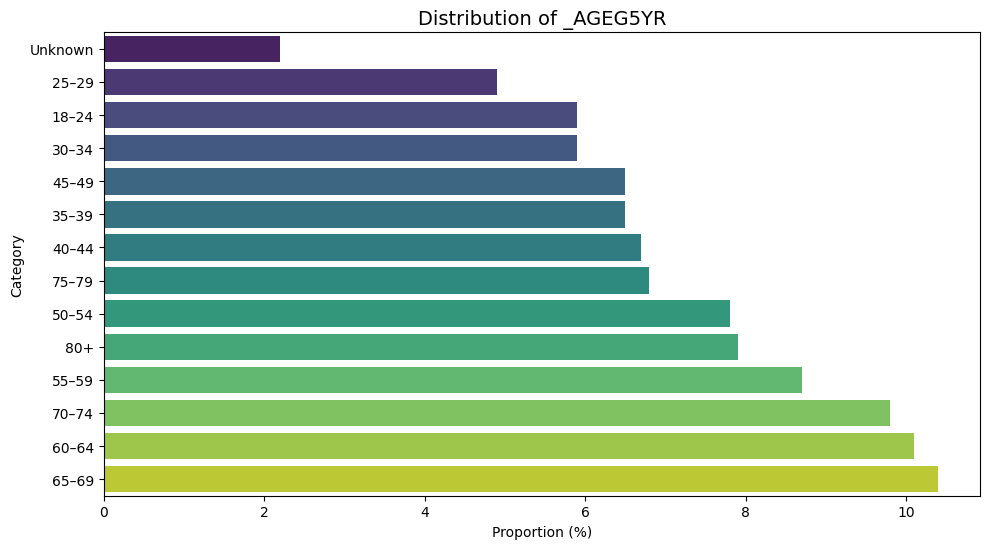

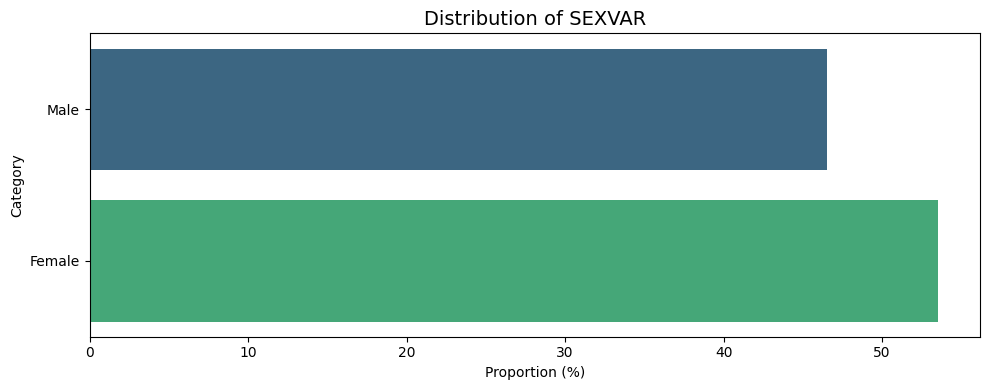

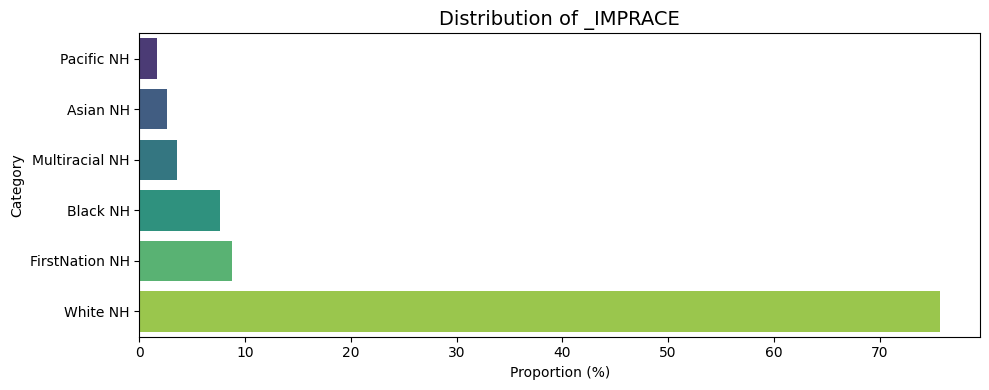

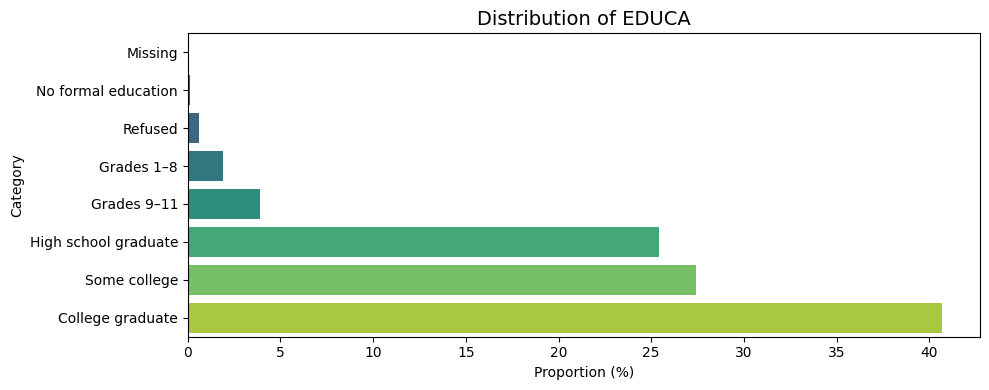

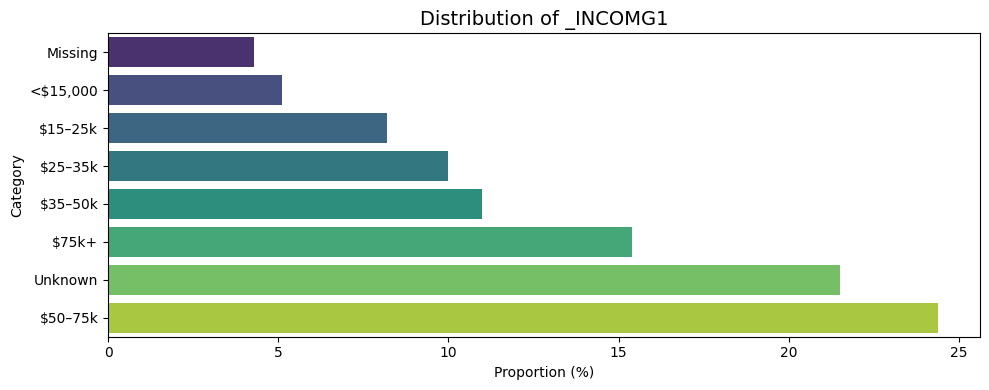

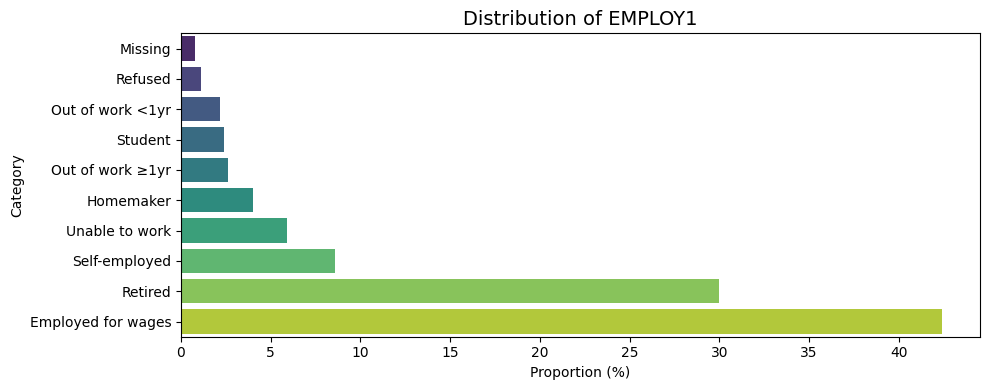

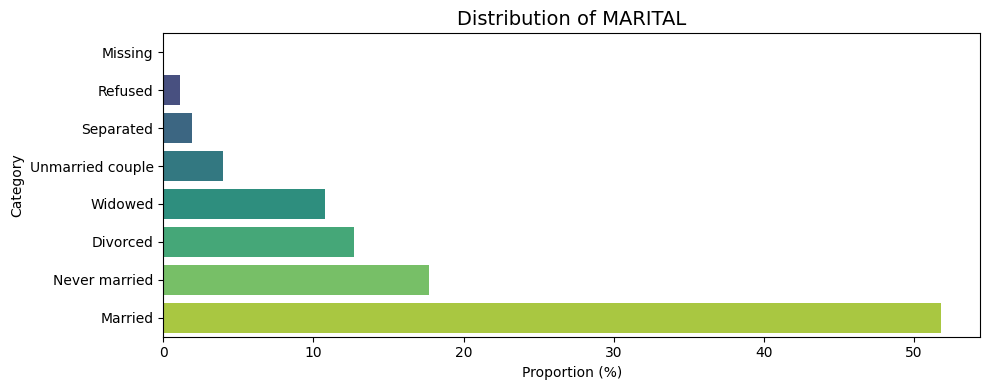

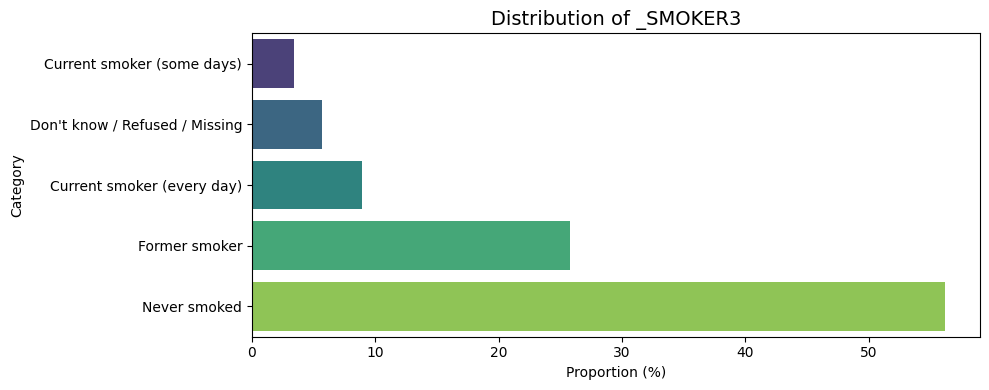

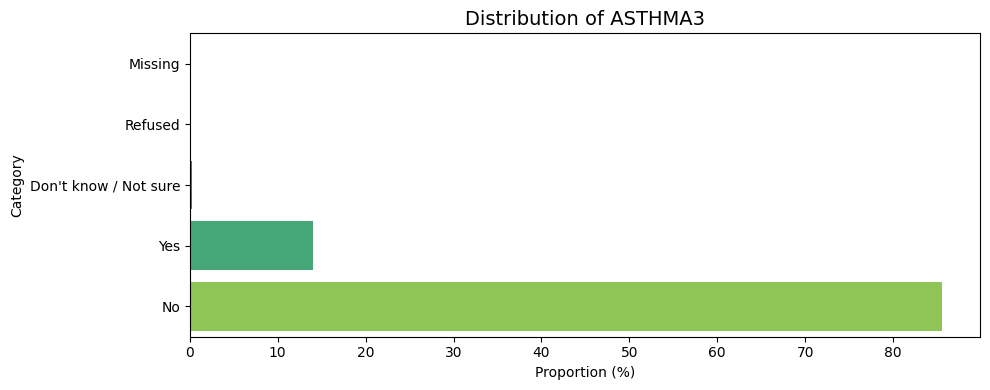

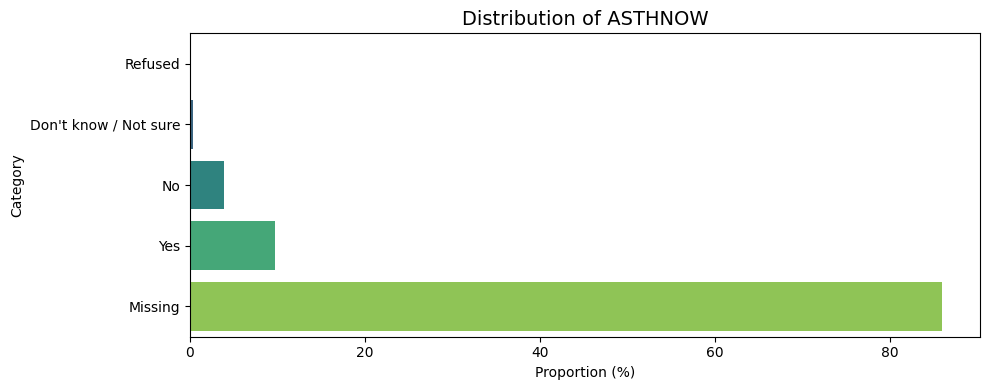

In [12]:
cat_summary_df = summarize_categorical(df_asthma, var_to_summarize)

plot_categorical_distribution(cat_summary_df)

## 4. Smoking and Asthma
We explore the relationship between smoking status (`_SMOKER3`) and asthma diagnosis (`ASTHMA3`). This is done using contingency tables and chi-square tests, to understand how smoking behavior varies by asthma status.

In [13]:
import scipy.stats as stats

# Only keep rows where _SMOKER3 is a valid category and ASTHMA3 is 'Yes' or 'No'
valid_smoker = ['Current smoker (every day)', 'Current smoker (some days)', 'Former smoker', 'Never smoked']
valid_asthma = ['Yes', 'No']
df_subset = df_asthma[
    df_asthma['_SMOKER3'].isin(valid_smoker) &
    df_asthma['ASTHMA3'].isin(valid_asthma)
].copy()

# Compare asthma rates (ASTHMA3 == 'Yes') across _SMOKER3 categories
asthma_rates = df_subset.groupby('_SMOKER3')['ASTHMA3'].value_counts(normalize=True).unstack().fillna(0)

contingency = pd.crosstab(df_subset['ASTHMA3'], df_subset['_SMOKER3'])
chi2, p_chi2, dof, expected = stats.chi2_contingency(contingency)

print("Contingency table (Asthma3 vs _SMOKER3):")
print(contingency.T)
print("\nContingency table (proportions, row-wise):")
print(contingency.div(contingency.sum(axis=1), axis=0).round(3))
print("\nContingency table (proportions, column-wise):")
print(contingency.div(contingency.sum(axis=0), axis=1).round(3))

print(f"\nChi-square test statistic: {chi2:.4f}")
print(f"Degrees of freedom: {dof}")

print(f"Chi-square test p-value: {p_chi2:.4e}")


Contingency table (Asthma3 vs _SMOKER3):
ASTHMA3                       Yes      No
_SMOKER3                                 
Current smoker (every day)   6749   31987
Current smoker (some days)   2463   12386
Former smoker               16273   96567
Never smoked                32956  212863

Contingency table (proportions, row-wise):
_SMOKER3  Current smoker (every day)  Current smoker (some days)  \
ASTHMA3                                                            
Yes                            0.115                       0.042   
No                             0.090                       0.035   

_SMOKER3  Former smoker  Never smoked  
ASTHMA3                                
Yes               0.278         0.564  
No                0.273         0.602  

Contingency table (proportions, column-wise):
_SMOKER3  Current smoker (every day)  Current smoker (some days)  \
ASTHMA3                                                            
Yes                            0.174           

## 5. BMI Distribution
This section processes the `_BMI5` variable, converting it from its raw scaled form to a standard BMI value. Implausible values are filtered, and we explore how BMI distributions (mean) differ across individuals with and without asthma using ANOVA.

In [14]:
# Reset the datatype of _SMOKER3 to categorical with the valid categories
df_subset['_SMOKER3'] = pd.Categorical(df_subset['_SMOKER3'], categories=valid_smoker)

In [15]:
print("df_subset shape:", df_subset.shape)

# Most extreme real-world BMI values are in the 60s to 70s, and those are exceedingly rare.
# Only include rows where BMI is less than 50
df_subset = df_subset[df_subset['_BMI5'] < 50]

print("df_subset shape (after filtering outliers):", df_subset.shape)

df_subset shape: (412244, 15)
df_subset shape (after filtering outliers): (377866, 15)


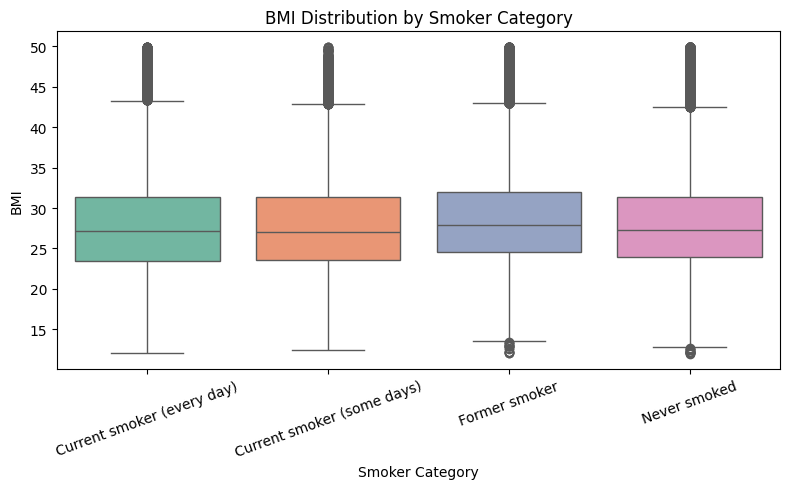

                   sum_sq        df           F         PR(>F)
C(_SMOKER3)  3.101263e+04       3.0  292.750951  7.670860e-190
Residual     1.334296e+07  377862.0         NaN            NaN


In [16]:
df_subset = df_subset[df_subset['_SMOKER3'].isin(valid_smoker)]
# Boxplot of BMI by smoker category
plt.figure(figsize=(8, 5))
sns.boxplot(x='_SMOKER3', y='_BMI5', data=df_subset, palette='Set2')
plt.xlabel('Smoker Category')
plt.ylabel('BMI')
plt.title('BMI Distribution by Smoker Category')
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

# Fit OLS model for ANOVA table
model = smf.ols('_BMI5 ~ C(_SMOKER3)', data=df_subset).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)


## 6. Visualizing Age Distribution for Asthma and Non-Asthma

Comparing different types of visualization to describe the difference in age distributions across Asthma and non-Asthma patients. Data storytelling.

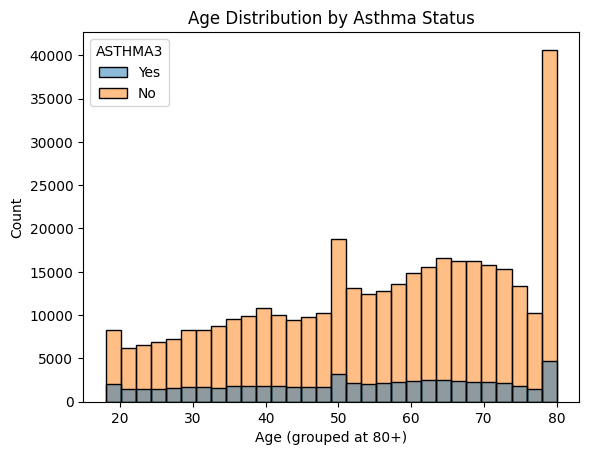

In [17]:
df_asthma_age=df_asthma[['_AGE80', 'ASTHMA3']].copy()
df_asthma_age['ASTHMA3'] = pd.Categorical(df_asthma_age['ASTHMA3'], categories=valid_asthma)

sns.histplot(data=df_asthma_age, x='_AGE80', hue='ASTHMA3', bins=30)
plt.title('Age Distribution by Asthma Status')
plt.xlabel('Age (grouped at 80+)')
plt.ylabel('Count')
plt.show()



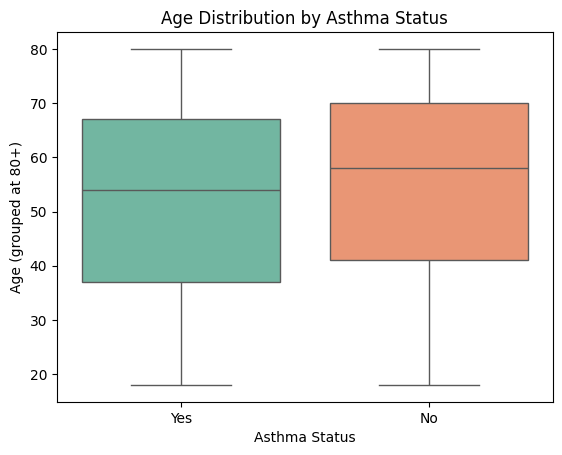

In [18]:
sns.boxplot(data=df_asthma_age, x='ASTHMA3', y='_AGE80', palette='Set2')
plt.title('Age Distribution by Asthma Status')
plt.xlabel('Asthma Status')
plt.ylabel('Age (grouped at 80+)')
plt.show()

🟢 Pros:
Shows distribution shape + summary stats
Great for sample sizes > 100

🔴 Cons:
Can be noisy for very small groups

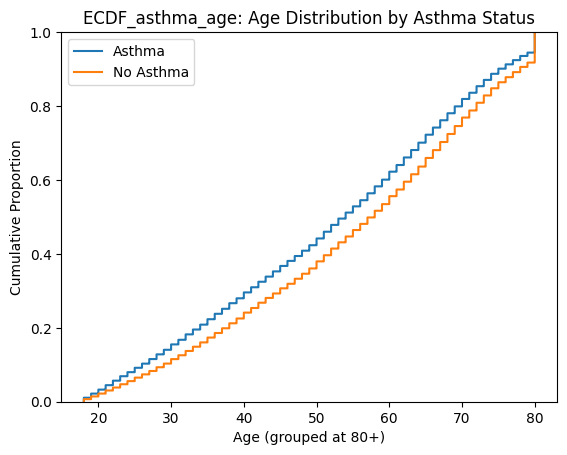

In [19]:
# ECDF_asthma_age plot using seaborn
sns.ecdfplot(data=df_asthma_age[df_asthma_age['ASTHMA3'] == 'Yes'], x='_AGE80', label='Asthma')
sns.ecdfplot(data=df_asthma_age[df_asthma_age['ASTHMA3'] == 'No'], x='_AGE80', label='No Asthma')

plt.title('ECDF_asthma_age: Age Distribution by Asthma Status')
plt.xlabel('Age (grouped at 80+)')
plt.ylabel('Cumulative Proportion')
plt.legend()
plt.show()

## 7. Using FIPS to map Asthma cases

We utilize Federal Information Processing Standards (FIPS) codes to map the geographical distribution of asthma prevalence across the U.S., offering spatial insights into regional patterns.

In [22]:
# Merge with fips_mapping on the STATE code
fips_mapping = pd.read_csv('https://raw.githubusercontent.com/seanlam74/CGH_SUTD_DVSA_Case_Study/refs/heads/main/state_fips.csv', delimiter='|')

# Ensure STATE is numeric to match _STATE in df_asthma
fips_mapping['STATE'] = fips_mapping['STATE'].astype(int)
df_asthma['_STATE'] = df_asthma['_STATE'].astype(int)

# Merge on STATE code
df_asthma = df_asthma.merge(fips_mapping, left_on='_STATE', right_on='STATE', how='left')


In [23]:
# Ensure 'ASTHMA3' and 'STATE' exist and are clean
df_valid = df_asthma[df_asthma['ASTHMA3'].isin(['Yes', 'No'])]

# Group by state to calculate proportions
state_totals = df_asthma.groupby('STUSAB').size().rename('Total')
state_yes = df_valid[df_valid['ASTHMA3'] == 'Yes'].groupby('STUSAB').size().rename('Yes')

# Combine and calculate proportion
state_proportions = pd.concat([state_yes, state_totals], axis=1)
state_proportions['Proportion'] = state_proportions['Yes'] / state_proportions['Total']
state_proportions = state_proportions.reset_index()

state_names = df_asthma[['STUSAB', 'STATE_NAME']].drop_duplicates()
state_proportions = state_proportions.merge(state_names, on='STUSAB', how='left')


In [24]:
# Plot choropleth map
import plotly.express as px

fig = px.choropleth(
    state_proportions,
    locations='STUSAB',
    locationmode="USA-states",
    color='Proportion',
    scope="usa",
    color_continuous_scale="Blues",
    labels={'Proportion': 'Asthma Prevalence'},
    title="Proportion of Asthma (Yes) Cases by State",
    hover_data={
        'STATE_NAME': True,
        'Yes': True,
        'Total': True,
        'Proportion': ':.2%'  # Display as percentage
    }
)

fig.update_layout(geo=dict(bgcolor='rgba(0,0,0,0)'))
fig.show()